Setting up the environment

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ColorJitter
#from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import time
import torchvision.transforms.functional as transf_F

Paths and directories

In [21]:
base_dir = '/kaggle/input/camvid/CamVid/'
train_dir = base_dir + 'train'
train_labels_dir = base_dir + 'train_labels'
val_dir = base_dir + 'val'
val_labels_dir = base_dir + 'val_labels'
test_dir = base_dir + 'test'
test_labels_dir = base_dir + 'test_labels'
class_dict_path = base_dir + 'class_dict.csv'

# File 리스트
train_files = os.listdir(train_dir) # len = 369
train_labels_files = os.listdir(train_labels_dir) # len = 369
val_files = os.listdir(val_dir) # len = 100
val_labels_files = os.listdir(val_labels_dir) # len = 100
test_files = os.listdir(test_dir) # len = 232
test_labels_files = os.listdir(test_labels_dir) # len = 232

train_files.sort()
train_labels_files.sort()
val_files.sort()
val_labels_files.sort()
test_files.sort()
test_labels_files.sort()

assert len(train_files) == len(train_labels_files) == 369
assert len(val_files) == len(val_labels_files) == 100
assert len(test_files) == len(test_labels_files) == 232

for i in train_files:
    assert i[:-4] + '_L.png' in train_labels_files, f'{i} not found'

for i in val_files:
    assert i[:-4] + '_L.png' in val_labels_files, f'{i} not found'

for i in test_files:
    assert i[:-4] + '_L.png' in test_labels_files, f'{i} not found'

print('ok')

ok


Torch device

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


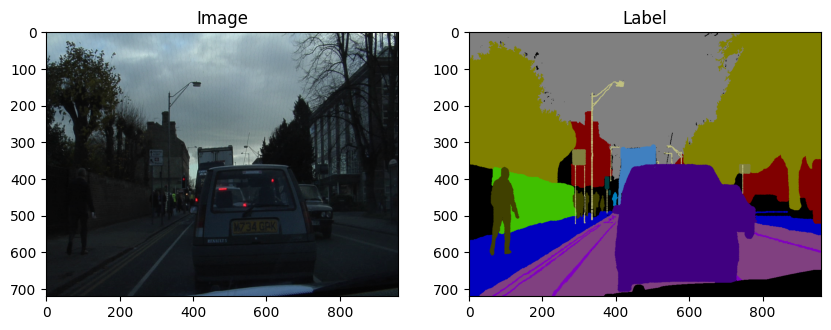

In [23]:
img_example = Image.open(os.path.join(train_dir, train_files[0]))
label_example = Image.open(os.path.join(train_labels_dir, train_labels_files[0]))

# Show the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_example)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(label_example)
plt.title('Label')

plt.show()

del(img_example, label_example)

Image tensor shape: torch.Size([4, 3, 360, 480]), <class 'torch.Tensor'>
Label tensor shape: torch.Size([4, 360, 480]), <class 'torch.Tensor'>


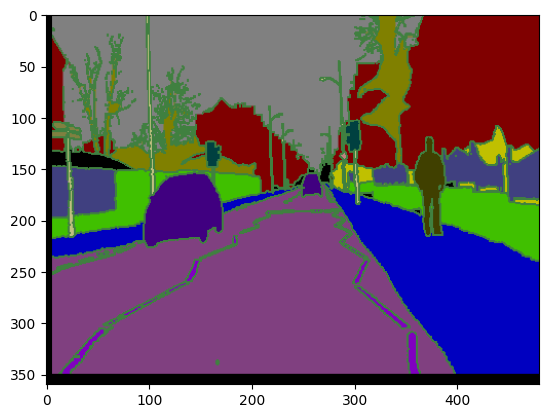

In [24]:
# Load class dictionary
class_dict: pd.DataFrame = pd.read_csv(class_dict_path)

# Create conversion dictionaries
rgb_to_label_dict: dict[tuple, int] = {
    (row['r'], row['g'], row['b']): idx
    for idx, row in class_dict.iterrows()
}

label_to_rgb_dict: dict[int, tuple] = {
    idx: (row['r'], row['g'], row['b'])
    for idx, row in class_dict.iterrows()
}

def rgb_to_label(image: torch.Tensor) -> torch.Tensor:
    width, height, _ = image.shape
    label_image = torch.zeros(width, height, device=device)

    # Transformar para inteiro, se necessário, para garantir comparação correta
    image = (image * 255).int()

    for rgb, label in rgb_to_label_dict.items():
        rgb_tensor = torch.tensor(rgb, device=device)
        mask = torch.all(image == rgb_tensor, dim=-1)
        label_image[mask] = label
        
    return label_image

def label_to_rgb_tensor(label_tensor: torch.Tensor) -> torch.Tensor:
    height, width = label_tensor.shape
    rgb_image = torch.zeros(3, height, width, dtype=torch.uint8)

    for label, rgb in label_to_rgb_dict.items():
        mask = (label_tensor == label)
        rgb_image[0][mask] = rgb[0]  # Red
        rgb_image[1][mask] = rgb[1]  # Green
        rgb_image[2][mask] = rgb[2]  # Blue

    return rgb_image

def read_image(image_path: str) -> torch.Tensor:
    image = Image.open(image_path)
    image = transforms.ToTensor()(image)
    return image

class CamVidDataset(Dataset):
    def __init__(self, img_dir: str, label_dir: str, augment: bool = False):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.Resize((360, 480)),
        ])
        self.img_files = os.listdir(img_dir)
        self.label_files = os.listdir(label_dir)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = img_file.replace(".png", "_L.png")

        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)

        img = read_image(img_path).to(device)
        label = read_image(label_path).to(device)

        img = self.transform(img)
        label = self.transform(label)
        
        if self.augment:
            if torch.rand(1) > 0.5:
                img = transf_F.hflip(img)
                label = transf_F.hflip(label)
            
            # Pad the image and label with the same padding value (using a tuple)
            img = transf_F.pad(img, (10, 10, 10, 10))  # padding on all sides
            label = transf_F.pad(label, (10, 10, 10, 10))  # padding on all sides
        

            # Apply the same cropping to both image and label
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(360, 480))
            img = transf_F.crop(img, i, j, h, w)
            label = transf_F.crop(label, i, j, h, w)
            
            # Color jitter only applies to the image
            img = transforms.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=0.2)(img)
        
        
        label = rgb_to_label(label.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)

        return img, label.long()

train_dataset = CamVidDataset(train_dir, train_labels_dir, augment=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

img, label = next(iter(train_loader))
print(f'Image tensor shape: {img.shape}, {type(img)}')
print(f'Label tensor shape: {label.shape}, {type(label)}')


rgb_tens = label_to_rgb_tensor(label[0])
rgb_image = Image.fromarray(rgb_tens.permute(1, 2, 0).numpy())
plt.imshow(rgb_image)
plt.show()

del(train_dataset, train_loader, img, label)          


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG16_FCN(nn.Module):
    def __init__(self, num_classes=21):
        super(VGG16_FCN, self).__init__()
        
        self.num_classes = num_classes

        self.features1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [1, 64, 112, 112]
        )
        
        self.features2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [1, 128, 56, 56]
        )
        
        self.features3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [1, 256, 28, 28]
        )

        self.features4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [1, 512, 14, 14]
        )

        self.features5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [1, 512, 7, 7]
        )

        # Fully connected conv layer
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5) # [1, 4096, 7, 7]
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5) # [1, 4096, 7, 7]
        )
        self.score = nn.Conv2d(4096, num_classes, kernel_size=1)  # [1, 21, 7, 7]

    def forward(self, x):
        # VGG16
        x1 = self.features1(x)  # [1, 64, 112, 112]
        x2 = self.features2(x1)  # [1, 128, 56, 56]
        x3 = self.features3(x2)  # [1, 256, 28, 28]
        x4 = self.features4(x3)  # [1, 512, 14, 14]
        x5 = self.features5(x4)  # [1, 512, 7, 7]

        # Fully connected conv layer
        x6 = self.conv6(x5)  # [1, 4096, 7, 7]
        x7 = self.conv7(x6)  # [1, 4096, 7, 7]
        score = self.score(x7)  # [1, 21, 7, 7]

        # FCN-32s
        fcn32 = F.interpolate(score, size=(224, 224), mode='bilinear', align_corners=False)  # [1, 21, 224, 224]

        # FCN-16s
        score2 = F.interpolate(score, size=(14, 14), mode='bilinear', align_corners=False)  # [1, 21, 14, 14]
        score4 = F.interpolate(self.score4(x4), size=(14, 14), mode='bilinear', align_corners=False)  # [1, 21, 14, 14] 
        score4_1 = score4 + score2  # [1, 21, 14, 14]
        fcn16 = F.interpolate(score4_1, size=(224, 224), mode='bilinear', align_corners=False)  # [1, 21, 224, 224]

        # FCN-8s
        score3 = F.interpolate(self.score3(x3), size=(28, 28), mode='bilinear', align_corners=False)  # [1, 21, 28, 28]
        score4_2 = F.interpolate(score4_1, size=(28, 28), mode='bilinear', align_corners=False)  # [1, 21, 28, 28]
        
        score3_1 = score3 + score4_2  # [1, 21, 28, 28]
        fcn8 = F.interpolate(score3_1, size=(224, 224), mode='bilinear', align_corners=False)  # [1, 21, 224, 224]

        return fcn8

# 가중치 초기화
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# check model
if __name__ == "__main__":
    model = VGG16_FCN(num_classes=21)
    model.apply(init_weights)
    input = torch.ones([1, 3, 224, 224])
    fcn8 = model(input)
    print(fcn8.shape)

torch.Size([1, 21, 224, 224])


In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for images, labels in train_loader:
            images = images.to(device) # Send data to device
            labels = labels.to(device) # Send data to device

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate pixel-wise accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_pixels / total_pixels

        # Validation phase
        model.eval()
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("="*100)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.4f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for images, labels in train_loader:
            images = images.to(device) # Send data to device
            labels = labels.to(device) # Send data to device

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate pixel-wise accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_pixels / total_pixels

        # Validation phase
        model.eval()
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("="*100)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.4f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if (epoch + 1) % 10 == 0:  # For example, visualize every 5 epochs
            visualize_segmentation(model, val_loader, device)

    return model, history


def validate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()
            
    val_loss = running_loss / len(val_loader)
    val_acc = correct_pixels / total_pixels

    return val_loss, val_acc

def visualize_segmentation(model, val_loader, device):
    model.eval()
    batch_idx = random.randint(0, len(val_loader) - 1)
    images, labels = list(val_loader)[batch_idx]
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    img_idx = random.randint(0, len(images) - 1)
    img = images[img_idx].cpu().numpy().transpose(1, 2, 0)
    label = labels[img_idx].cpu().numpy()
    pred = preds[img_idx].cpu().numpy()
    pred_rgb = label_to_rgb_tensor(pred).cpu().numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    
    axes[1].imshow(label_to_rgb_tensor(label).permute(1, 2, 0).cpu().numpy())
    axes[1].set_title('Ground Truth')

    axes[2].imshow(pred_rgb)
    axes[2].set_title('Predicted Mask')

    plt.show()

In [27]:
# Dataset and DataLoader
train_dataset = CamVidDataset(img_dir=train_dir, label_dir=train_labels_dir)
val_dataset = CamVidDataset(img_dir=val_dir, label_dir=val_labels_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

In [28]:
# Model, criterion, optimizer
model = VGG16_FCN(num_classes=32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch [1/100] - Time: 48.7905s
Train Loss: 1.5385, Train Acc: 0.5478
Val Loss: 1.3750, Val Acc: 0.5959
Epoch [2/100] - Time: 39.6408s
Train Loss: 1.1475, Train Acc: 0.6682
Val Loss: 1.5976, Val Acc: 0.5150
Epoch [3/100] - Time: 38.9384s
Train Loss: 1.0405, Train Acc: 0.6956
Val Loss: 1.0437, Val Acc: 0.6925
Epoch [4/100] - Time: 39.0610s
Train Loss: 0.9395, Train Acc: 0.7226
Val Loss: 0.9840, Val Acc: 0.7135
Epoch [5/100] - Time: 39.1934s
Train Loss: 0.8825, Train Acc: 0.7384
Val Loss: 0.9978, Val Acc: 0.6975
Epoch [6/100] - Time: 39.5857s
Train Loss: 0.8195, Train Acc: 0.7553
Val Loss: 0.8033, Val Acc: 0.7564
Epoch [7/100] - Time: 39.4975s
Train Loss: 0.8153, Train Acc: 0.7545
Val Loss: 0.7620, Val Acc: 0.7724
Epoch [8/100] - Time: 39.5360s
Train Loss: 0.7942, Train Acc: 0.7592
Val Loss: 0.9021, Val Acc: 0.7401
Epoch [9/100] - Time: 39.1801s
Train Loss: 0.7366, Train Acc: 0.7769
Val Loss: 0.8819, Val Acc: 0.7332
Epoch [10/100] - Time: 39.2630s
Train Loss: 0.6823, Train Acc: 0.7894
Val

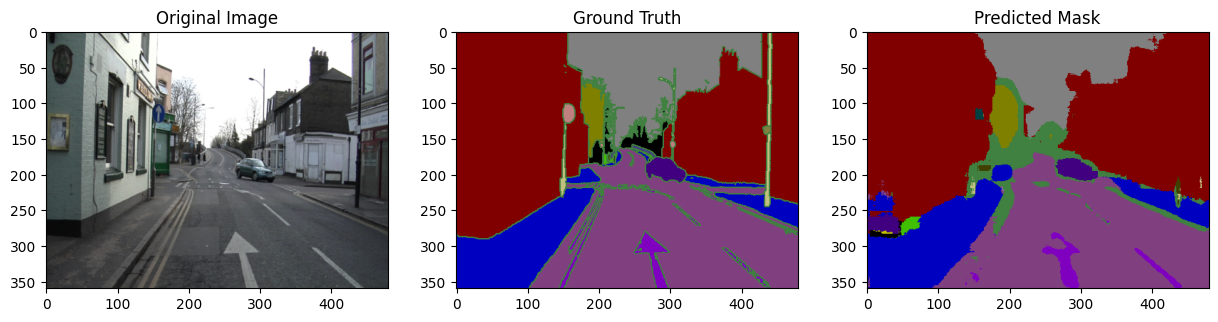

Epoch [11/100] - Time: 39.0337s
Train Loss: 0.6632, Train Acc: 0.7957
Val Loss: 0.6843, Val Acc: 0.7918
Epoch [12/100] - Time: 39.2479s
Train Loss: 0.6547, Train Acc: 0.7971
Val Loss: 0.6664, Val Acc: 0.8018
Epoch [13/100] - Time: 39.5689s
Train Loss: 0.6289, Train Acc: 0.8034
Val Loss: 0.7841, Val Acc: 0.7613
Epoch [14/100] - Time: 39.2898s
Train Loss: 0.6788, Train Acc: 0.7898
Val Loss: 0.7957, Val Acc: 0.7508
Epoch [15/100] - Time: 39.1459s
Train Loss: 0.6116, Train Acc: 0.8072
Val Loss: 0.6349, Val Acc: 0.8066
Epoch [16/100] - Time: 38.9304s
Train Loss: 0.5836, Train Acc: 0.8163
Val Loss: 0.6328, Val Acc: 0.8024
Epoch [17/100] - Time: 39.6962s
Train Loss: 0.5587, Train Acc: 0.8214
Val Loss: 0.6174, Val Acc: 0.8120
Epoch [18/100] - Time: 40.1365s
Train Loss: 0.5693, Train Acc: 0.8200
Val Loss: 0.6324, Val Acc: 0.8069
Epoch [19/100] - Time: 39.6618s
Train Loss: 0.5424, Train Acc: 0.8259
Val Loss: 0.6208, Val Acc: 0.8080
Epoch [20/100] - Time: 39.4613s
Train Loss: 0.5373, Train Acc: 0

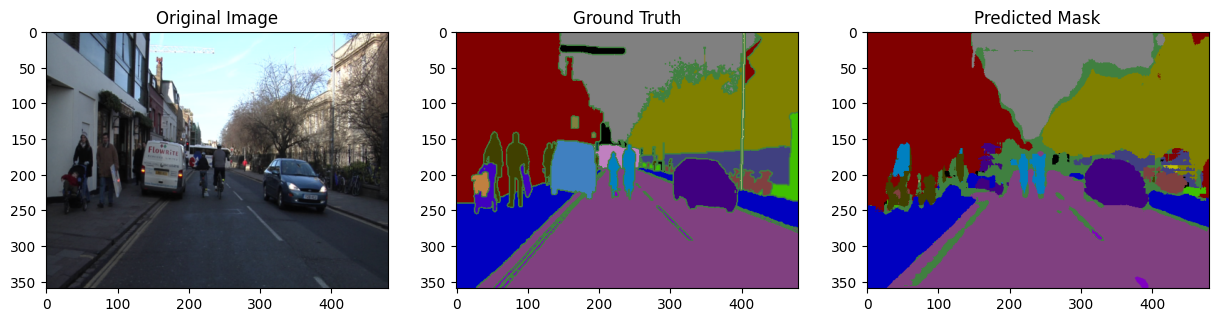

Epoch [21/100] - Time: 40.1597s
Train Loss: 0.5216, Train Acc: 0.8325
Val Loss: 0.5685, Val Acc: 0.8217
Epoch [22/100] - Time: 40.0774s
Train Loss: 0.5661, Train Acc: 0.8191
Val Loss: 0.6111, Val Acc: 0.8140
Epoch [23/100] - Time: 39.6505s
Train Loss: 0.5082, Train Acc: 0.8360
Val Loss: 0.5377, Val Acc: 0.8305
Epoch [24/100] - Time: 38.8922s
Train Loss: 0.4922, Train Acc: 0.8383
Val Loss: 0.5390, Val Acc: 0.8301
Epoch [25/100] - Time: 39.0191s
Train Loss: 0.4640, Train Acc: 0.8475
Val Loss: 0.5214, Val Acc: 0.8332
Epoch [26/100] - Time: 39.2436s
Train Loss: 0.4634, Train Acc: 0.8462
Val Loss: 0.6193, Val Acc: 0.8097
Epoch [27/100] - Time: 39.3474s
Train Loss: 0.4665, Train Acc: 0.8464
Val Loss: 0.5053, Val Acc: 0.8379
Epoch [28/100] - Time: 38.9591s
Train Loss: 0.4352, Train Acc: 0.8543
Val Loss: 0.5541, Val Acc: 0.8231
Epoch [29/100] - Time: 39.1872s
Train Loss: 0.4483, Train Acc: 0.8521
Val Loss: 0.5387, Val Acc: 0.8278
Epoch [30/100] - Time: 38.8234s
Train Loss: 0.4405, Train Acc: 0

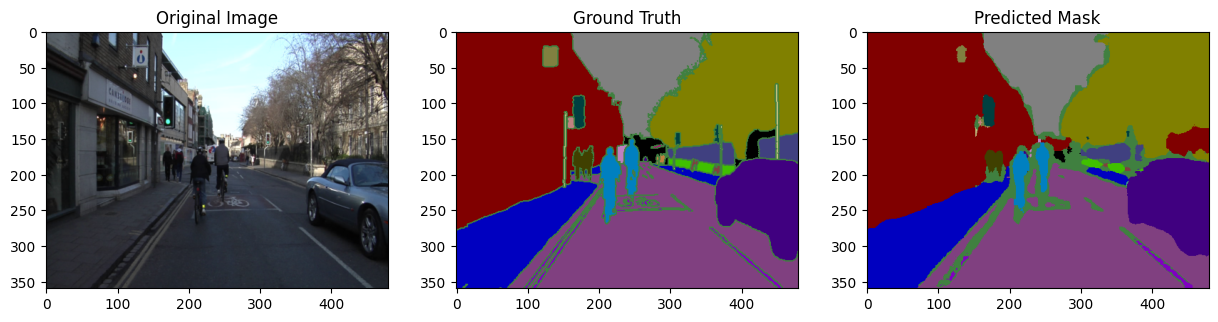

Epoch [31/100] - Time: 39.0431s
Train Loss: 0.4567, Train Acc: 0.8487
Val Loss: 0.5371, Val Acc: 0.8340
Epoch [32/100] - Time: 39.2611s
Train Loss: 0.4473, Train Acc: 0.8505
Val Loss: 0.5429, Val Acc: 0.8338
Epoch [33/100] - Time: 39.5690s
Train Loss: 0.4174, Train Acc: 0.8598
Val Loss: 0.5157, Val Acc: 0.8399
Epoch [34/100] - Time: 39.5704s
Train Loss: 0.4193, Train Acc: 0.8593
Val Loss: 0.4831, Val Acc: 0.8452
Epoch [35/100] - Time: 39.2037s
Train Loss: 0.3971, Train Acc: 0.8663
Val Loss: 0.4926, Val Acc: 0.8426
Epoch [36/100] - Time: 39.4243s
Train Loss: 0.3891, Train Acc: 0.8672
Val Loss: 0.4812, Val Acc: 0.8450
Epoch [37/100] - Time: 38.8347s
Train Loss: 0.3901, Train Acc: 0.8677
Val Loss: 0.5016, Val Acc: 0.8417
Epoch [38/100] - Time: 39.3091s
Train Loss: 0.3679, Train Acc: 0.8732
Val Loss: 0.4686, Val Acc: 0.8536
Epoch [39/100] - Time: 38.7783s
Train Loss: 0.3624, Train Acc: 0.8752
Val Loss: 0.5363, Val Acc: 0.8304
Epoch [40/100] - Time: 39.5208s
Train Loss: 0.3838, Train Acc: 0

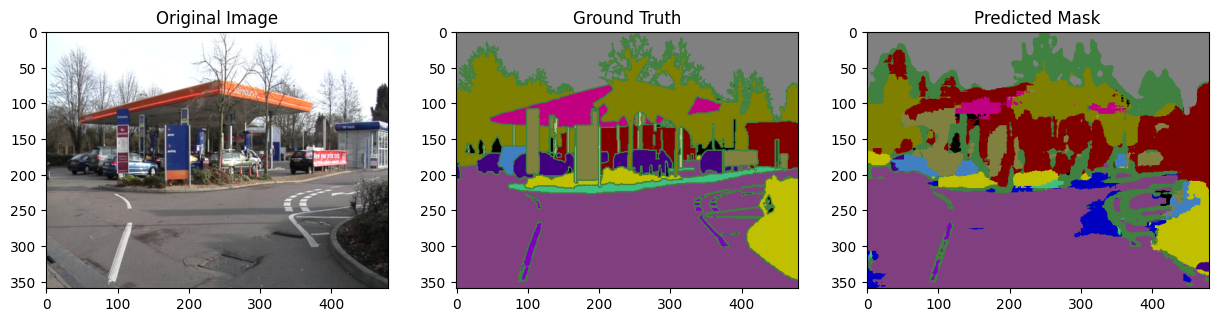

Epoch [41/100] - Time: 39.4098s
Train Loss: 0.5358, Train Acc: 0.8263
Val Loss: 0.5241, Val Acc: 0.8373
Epoch [42/100] - Time: 39.2601s
Train Loss: 0.3866, Train Acc: 0.8684
Val Loss: 0.4614, Val Acc: 0.8527
Epoch [43/100] - Time: 38.7373s
Train Loss: 0.3610, Train Acc: 0.8752
Val Loss: 0.4583, Val Acc: 0.8519
Epoch [44/100] - Time: 39.6026s
Train Loss: 0.3477, Train Acc: 0.8801
Val Loss: 0.4547, Val Acc: 0.8571
Epoch [45/100] - Time: 39.3196s
Train Loss: 0.3424, Train Acc: 0.8814
Val Loss: 0.4628, Val Acc: 0.8513
Epoch [46/100] - Time: 39.6679s
Train Loss: 0.3326, Train Acc: 0.8839
Val Loss: 0.4603, Val Acc: 0.8527
Epoch [47/100] - Time: 40.0850s
Train Loss: 0.3197, Train Acc: 0.8874
Val Loss: 0.4509, Val Acc: 0.8580
Epoch [48/100] - Time: 39.3591s
Train Loss: 0.3082, Train Acc: 0.8912
Val Loss: 0.4292, Val Acc: 0.8637
Epoch [49/100] - Time: 39.4480s
Train Loss: 0.3064, Train Acc: 0.8924
Val Loss: 0.4430, Val Acc: 0.8617
Epoch [50/100] - Time: 39.5890s
Train Loss: 0.3025, Train Acc: 0

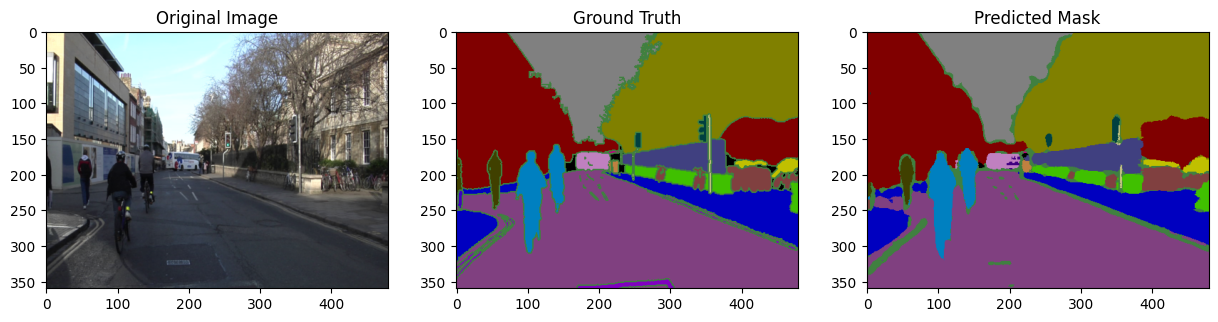

Epoch [51/100] - Time: 39.8349s
Train Loss: 0.3007, Train Acc: 0.8936
Val Loss: 0.5647, Val Acc: 0.8260
Epoch [52/100] - Time: 40.0782s
Train Loss: 0.3376, Train Acc: 0.8825
Val Loss: 0.4564, Val Acc: 0.8552
Epoch [53/100] - Time: 38.9932s
Train Loss: 0.3192, Train Acc: 0.8880
Val Loss: 0.4489, Val Acc: 0.8604
Epoch [54/100] - Time: 39.4647s
Train Loss: 0.3120, Train Acc: 0.8907
Val Loss: 0.4524, Val Acc: 0.8590
Epoch [55/100] - Time: 39.6332s
Train Loss: 0.2928, Train Acc: 0.8954
Val Loss: 0.4202, Val Acc: 0.8680
Epoch [56/100] - Time: 39.7278s
Train Loss: 0.2885, Train Acc: 0.8966
Val Loss: 0.4374, Val Acc: 0.8680
Epoch [57/100] - Time: 39.7659s
Train Loss: 0.2796, Train Acc: 0.9000
Val Loss: 0.4523, Val Acc: 0.8609
Epoch [58/100] - Time: 39.5020s
Train Loss: 0.2819, Train Acc: 0.8984
Val Loss: 0.4545, Val Acc: 0.8641
Epoch [59/100] - Time: 39.2422s
Train Loss: 0.2687, Train Acc: 0.9029
Val Loss: 0.4394, Val Acc: 0.8697
Epoch [60/100] - Time: 39.3072s
Train Loss: 0.2659, Train Acc: 0

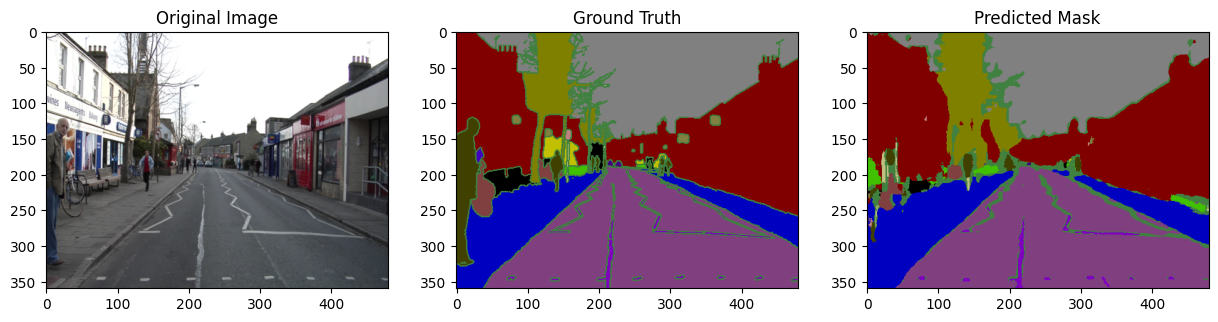

Epoch [61/100] - Time: 39.4884s
Train Loss: 0.2855, Train Acc: 0.8975
Val Loss: 0.4634, Val Acc: 0.8591
Epoch [62/100] - Time: 39.3433s
Train Loss: 0.2753, Train Acc: 0.9003
Val Loss: 0.4423, Val Acc: 0.8648
Epoch [63/100] - Time: 40.0484s
Train Loss: 0.2597, Train Acc: 0.9054
Val Loss: 0.4250, Val Acc: 0.8689
Epoch [64/100] - Time: 39.7435s
Train Loss: 0.2498, Train Acc: 0.9085
Val Loss: 0.4243, Val Acc: 0.8722
Epoch [65/100] - Time: 40.0012s
Train Loss: 0.2430, Train Acc: 0.9104
Val Loss: 0.4211, Val Acc: 0.8736
Epoch [66/100] - Time: 40.0748s
Train Loss: 0.2435, Train Acc: 0.9103
Val Loss: 0.4324, Val Acc: 0.8710
Epoch [67/100] - Time: 39.6393s
Train Loss: 0.2406, Train Acc: 0.9109
Val Loss: 0.4406, Val Acc: 0.8663
Epoch [68/100] - Time: 39.2007s
Train Loss: 0.2379, Train Acc: 0.9117
Val Loss: 0.5587, Val Acc: 0.8493
Epoch [69/100] - Time: 39.7199s
Train Loss: 0.5611, Train Acc: 0.8256
Val Loss: 0.5532, Val Acc: 0.8260
Epoch [70/100] - Time: 40.0671s
Train Loss: 0.3581, Train Acc: 0

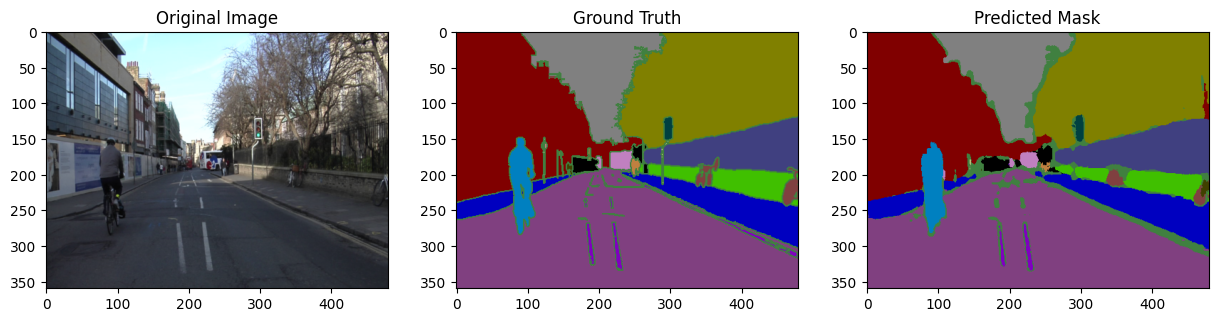

Epoch [71/100] - Time: 40.5143s
Train Loss: 0.2940, Train Acc: 0.8958
Val Loss: 0.4362, Val Acc: 0.8658
Epoch [72/100] - Time: 39.1244s
Train Loss: 0.2689, Train Acc: 0.9026
Val Loss: 0.4397, Val Acc: 0.8695
Epoch [73/100] - Time: 39.0282s
Train Loss: 0.2456, Train Acc: 0.9098
Val Loss: 0.4273, Val Acc: 0.8690
Epoch [74/100] - Time: 39.0395s
Train Loss: 0.2467, Train Acc: 0.9099
Val Loss: 0.4075, Val Acc: 0.8744
Epoch [75/100] - Time: 39.1299s
Train Loss: 0.2515, Train Acc: 0.9099
Val Loss: 0.4536, Val Acc: 0.8679
Epoch [76/100] - Time: 40.6285s
Train Loss: 0.2553, Train Acc: 0.9066
Val Loss: 0.4253, Val Acc: 0.8705
Epoch [77/100] - Time: 39.7506s
Train Loss: 0.2380, Train Acc: 0.9117
Val Loss: 0.4218, Val Acc: 0.8749
Epoch [78/100] - Time: 39.5072s
Train Loss: 0.2228, Train Acc: 0.9166
Val Loss: 0.4325, Val Acc: 0.8723
Epoch [79/100] - Time: 39.3048s
Train Loss: 0.2188, Train Acc: 0.9176
Val Loss: 0.4232, Val Acc: 0.8751
Epoch [80/100] - Time: 40.1317s
Train Loss: 0.2192, Train Acc: 0

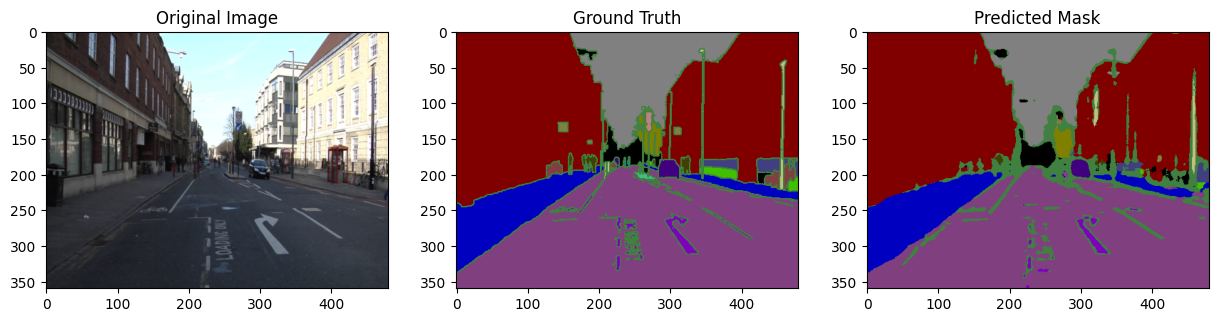

Epoch [81/100] - Time: 38.9934s
Train Loss: 0.2186, Train Acc: 0.9183
Val Loss: 0.4380, Val Acc: 0.8736
Epoch [82/100] - Time: 39.0918s
Train Loss: 0.2154, Train Acc: 0.9188
Val Loss: 0.4367, Val Acc: 0.8742
Epoch [83/100] - Time: 40.0051s
Train Loss: 0.2310, Train Acc: 0.9189
Val Loss: 0.6449, Val Acc: 0.8355
Epoch [84/100] - Time: 38.8710s
Train Loss: 0.4288, Train Acc: 0.8578
Val Loss: 0.4545, Val Acc: 0.8567
Epoch [85/100] - Time: 39.0249s
Train Loss: 0.2836, Train Acc: 0.8984
Val Loss: 0.4173, Val Acc: 0.8715
Epoch [86/100] - Time: 38.9578s
Train Loss: 0.2345, Train Acc: 0.9134
Val Loss: 0.4163, Val Acc: 0.8735
Epoch [87/100] - Time: 39.0804s
Train Loss: 0.2247, Train Acc: 0.9161
Val Loss: 0.4254, Val Acc: 0.8732
Epoch [88/100] - Time: 39.6898s
Train Loss: 0.2141, Train Acc: 0.9194
Val Loss: 0.4145, Val Acc: 0.8774
Epoch [89/100] - Time: 39.2989s
Train Loss: 0.2113, Train Acc: 0.9210
Val Loss: 0.4126, Val Acc: 0.8776
Epoch [90/100] - Time: 38.9668s
Train Loss: 0.2161, Train Acc: 0

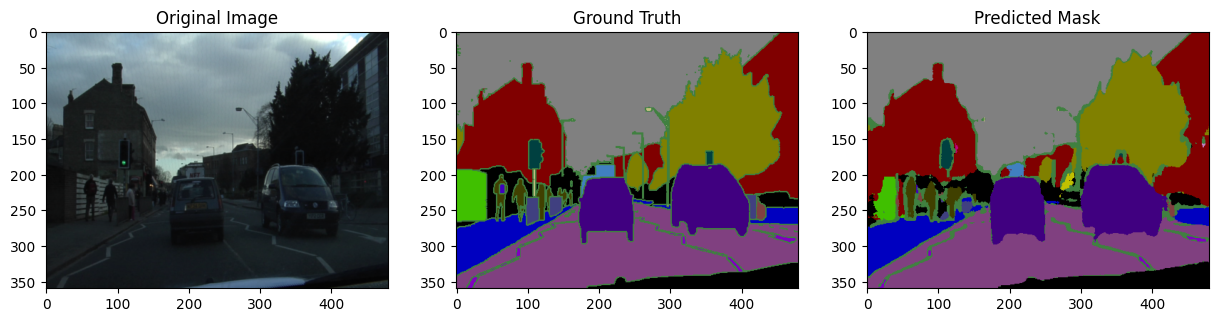

Epoch [91/100] - Time: 39.7226s
Train Loss: 0.2218, Train Acc: 0.9176
Val Loss: 0.4178, Val Acc: 0.8761
Epoch [92/100] - Time: 39.1258s
Train Loss: 0.2028, Train Acc: 0.9230
Val Loss: 0.4295, Val Acc: 0.8758
Epoch [93/100] - Time: 39.0687s
Train Loss: 0.1997, Train Acc: 0.9240
Val Loss: 0.4359, Val Acc: 0.8756
Epoch [94/100] - Time: 39.5562s
Train Loss: 0.1980, Train Acc: 0.9247
Val Loss: 0.4292, Val Acc: 0.8759
Epoch [95/100] - Time: 39.7336s
Train Loss: 0.1977, Train Acc: 0.9245
Val Loss: 0.4295, Val Acc: 0.8763
Epoch [96/100] - Time: 39.2098s
Train Loss: 0.1948, Train Acc: 0.9256
Val Loss: 0.4419, Val Acc: 0.8774
Epoch [97/100] - Time: 38.7682s
Train Loss: 0.1919, Train Acc: 0.9266
Val Loss: 0.4408, Val Acc: 0.8744
Epoch [98/100] - Time: 38.5011s
Train Loss: 0.1953, Train Acc: 0.9251
Val Loss: 0.4401, Val Acc: 0.8741
Epoch [99/100] - Time: 39.0469s
Train Loss: 0.1894, Train Acc: 0.9273
Val Loss: 0.4287, Val Acc: 0.8787
Epoch [100/100] - Time: 38.6927s
Train Loss: 0.1864, Train Acc: 

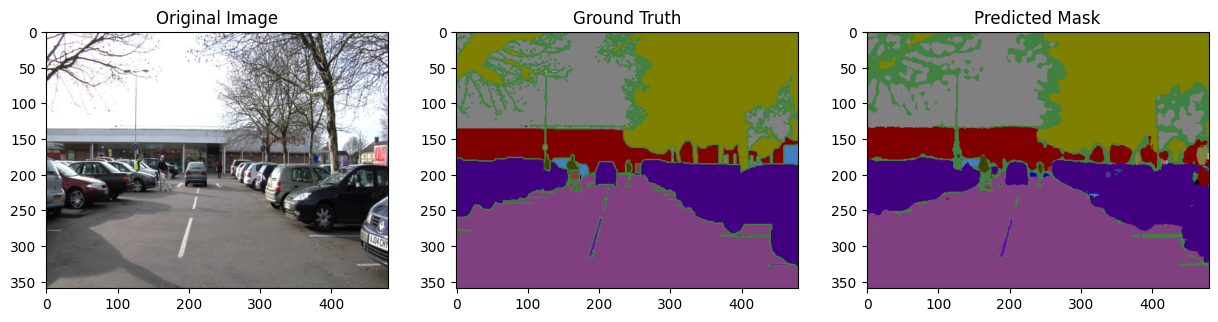

In [29]:
# Train and validate the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda')

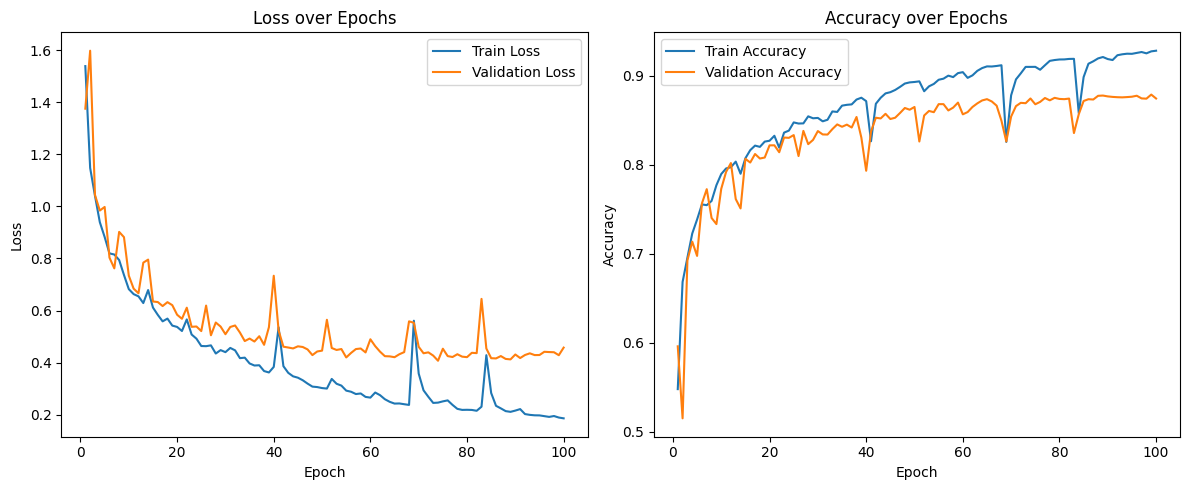

In [30]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(history)


In [32]:
# Create datasets with augmentation applied only to the training set
train_dataset_aug = CamVidDataset(img_dir=train_dir, label_dir=train_labels_dir, augment=True)
val_dataset_aug = CamVidDataset(img_dir=val_dir, label_dir=val_labels_dir, augment=True)

train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=4, shuffle=True)
val_loader_aug = torch.utils.data.DataLoader(val_dataset_aug, batch_size=4, shuffle=True)

# Model, criterion, optimizer (no augmentation)
model_aug = VGG16_FCN(num_classes=32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#summary(model, (3, 360, 480))


## Testing the model

In [38]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)  # Move the model to the correct device (GPU or CPU)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)  # Move the image to the correct device (GPU or CPU)
            label = label.to(device)  # Move the label to the correct device (GPU or CPU)
            
            # Forward pass
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu())  # Move predictions to CPU to store them
            all_labels.append(label.cpu())  # Move labels to CPU to store them
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_preds, all_labels


In [39]:
# Define the test dataset and DataLoader
test_dataset = CamVidDataset(img_dir=test_dir, label_dir=test_labels_dir, augment=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_loader, device='cuda')

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
 
def compute_accuracy(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.numel()
    accuracy = correct / total
    return accuracy

def compute_iou(preds, labels, num_classes):
    iou_list = []
    for i in range(num_classes):
        pred_i = (preds == i)
        label_i = (labels == i)
        intersection = (pred_i & label_i).sum().item()
        union = (pred_i | label_i).sum().item()
        iou = intersection / union if union != 0 else 0
        iou_list.append(iou)
    return np.mean(iou_list)

def compute_precision_recall_f1(preds, labels, num_classes):
    preds = preds.numpy()
    labels = labels.numpy()
    
    precision = precision_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    recall = recall_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    f1 = f1_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    
    return precision, recall, f1

# Compute accuracy
accuracy = compute_accuracy(test_preds, test_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Compute IoU
num_classes = 32  # number of classes in the dataset
iou = compute_iou(test_preds, test_labels, num_classes)
print(f'Mean IoU: {iou:.4f}')

# Compute Precision, Recall, F1-Score
precision, recall, f1 = compute_precision_recall_f1(test_preds, test_labels, num_classes)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Test Accuracy: 84.64%
Mean IoU: 0.3693
Precision: 0.8441
Recall: 0.8464
F1-Score: 0.8399
